In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import classification_report

In [2]:
train_path = "../data/raw/spider_classification/train"
val_path = "../data/raw/spider_classification/valid"

In [3]:
# Image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
NUM_CLASSES = 15

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2185 images belonging to 15 classes.


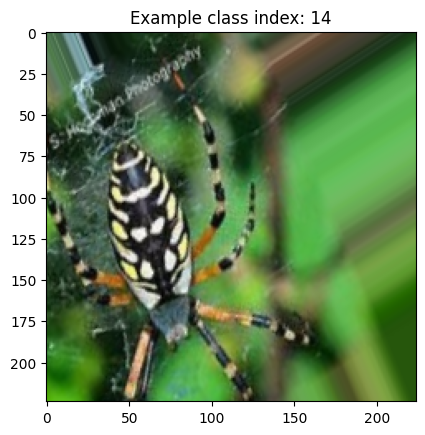

In [7]:
x_batch, y_batch = next(train_generator)
plt.imshow(x_batch[0])
plt.title(f"Example class index: {np.argmax(y_batch[0])}")
plt.show()


In [8]:
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 75 images belonging to 15 classes.


In [9]:
# =====================
# Model Architecture
# =====================
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
checkpoint = ModelCheckpoint(
    'best_model.keras',          # Use .keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [13]:
# =====================
# Train Model
# =====================
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

C:\Users\Owner\PycharmProjects\tarantula-species-image-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1084 - loss: 6.0338
Epoch 1: val_accuracy improved from -inf to 0.06667, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1084 - loss: 5.9780 - val_accuracy: 0.0667 - val_loss: 7.5928
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1491 - loss: 2.5807
Epoch 2: val_accuracy did not improve from 0.06667
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1492 - loss: 2.5807 - val_accuracy: 0.0667 - val_loss: 9.6823
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1678 - loss: 2.5689
Epoch 3: val_accuracy did not improve from 0.06667
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1682 - loss: 2.5678 - val_accuracy: 0.0667 - val_loss: 10.8591
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1754 - loss: 2.5151
Epoch 4: val_accuracy did not improve from 0.06667
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1751 - loss: 2.5154 - val_accu

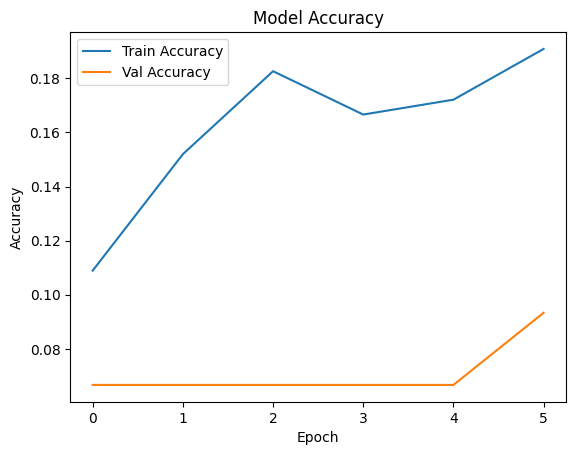

In [14]:
# =====================
# Plot Performance
# =====================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

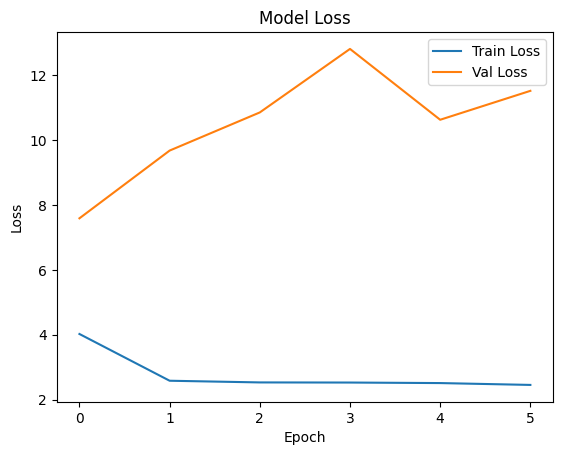

In [15]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Get predictions on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)           # predicted class indices
y_true = val_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


In [17]:
# Get class labels
labels = list(val_generator.class_indices.keys())

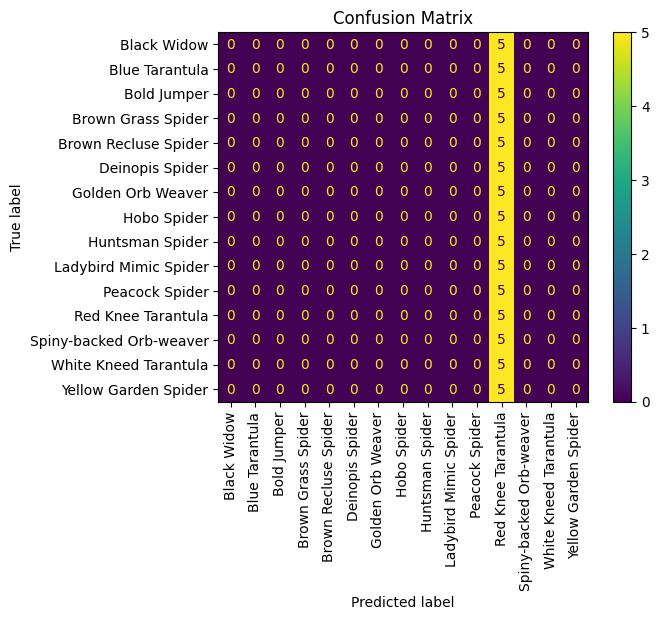

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

Classification Report:
                         precision    recall  f1-score   support

            Black Widow       0.00      0.00      0.00         5
         Blue Tarantula       0.00      0.00      0.00         5
            Bold Jumper       0.00      0.00      0.00         5
     Brown Grass Spider       0.00      0.00      0.00         5
   Brown Recluse Spider       0.00      0.00      0.00         5
        Deinopis Spider       0.00      0.00      0.00         5
      Golden Orb Weaver       0.00      0.00      0.00         5
            Hobo Spider       0.00      0.00      0.00         5
        Huntsman Spider       0.00      0.00      0.00         5
  Ladybird Mimic Spider       0.00      0.00      0.00         5
         Peacock Spider       0.00      0.00      0.00         5
     Red Knee Tarantula       0.07      1.00      0.12         5
Spiny-backed Orb-weaver       0.00      0.00      0.00         5
  White Kneed Tarantula       0.00      0.00      0.00         5
 

In [21]:
import numpy as np
print("Classes predicted:", np.unique(y_pred))
print("Classes in validation set:", np.unique(y_true))

Classes predicted: [11]
Classes in validation set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [22]:
import collections
print("Predicted class distribution:")
print(collections.Counter(y_pred))

Predicted class distribution:
Counter({np.int64(11): 75})


In [23]:
import collections
print(collections.Counter(train_generator.classes))

Counter({np.int32(2): 189, np.int32(14): 177, np.int32(8): 168, np.int32(1): 160, np.int32(10): 157, np.int32(12): 154, np.int32(6): 153, np.int32(7): 152, np.int32(4): 140, np.int32(3): 136, np.int32(11): 127, np.int32(13): 126, np.int32(0): 122, np.int32(5): 120, np.int32(9): 104})
